# Uncovering Global Development Gaps: The Role of Zero-Weight Edges

![Global Development Networks](/images/global_connections.png "Visualization of Trade and Similarity Networks")
## The Challenge
Countries are interconnected through trade, investment, and shared development challenges. But what happens when these connections are missing or negligible (zero-weight edges)? These gaps can distort our understanding of global networks, affecting everything from trade influence to environmental cooperation.

## Our Goal
Using World Bank data, we’ll build two networks:
1. A **trade/influence network** based on exports and FDI to test influence and connectivity.
2. A **similarity network** based on CO2 emissions and electricity access to identify development communities.
We’ll test how NetworkX algorithms handle zero-weight edges and uncover insights for global development.

## Why It Matters
Zero-weight edges might represent missing trade links, environmental disparities, or data gaps. Understanding their impact can help policymakers address isolation, foster cooperation, and improve data collection.


In [9]:
# Import required libraries
import wbdata
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
from sklearn.preprocessing import StandardScaler
from collections import Counter
from scipy.spatial import ConvexHull
from matplotlib.lines import Line2D

import warnings
warnings.filterwarnings('ignore')

try:
    import community as community_louvain
    louvain_installed = True
except ImportError:
    louvain_installed = False
    print("Warning: 'python-louvain' package not installed. Louvain test will be skipped.")

# Set random seed for reproducibility
np.random.seed(42)





In [10]:
louvain_installed

True

## Data Collection and Preprocessing

### 1. Data Collection
We'll fetch data from the World Bank's World Development Indicators database using the `wbdata` package.

We select indicators that reflect economic connectivity, environmental impact, and infrastructure:
- Exports (% of GDP): For trade relationships.
- FDI outflows (% of GDP): For investment influence.
- CO2 emissions per capita: For environmental similarity.
- Access to electricity: For socio-economic similarity.
- GDP per capita: For context and filtering.

In [11]:

indicators = {
    "NE.EXP.GNFS.ZS": "Exports (% of GDP)",
    "BM.KLT.DINV.WD.GD.ZS": "FDI Outflows (% of GDP)",
    "EN.GHG.ALL.MT.CE.AR5": "CO2 Emissions per Capita",
    "EG.ELC.ACCS.ZS": "Access to Electricity",
    "NY.GDP.PCAP.CD": "GDP per Capita"
}

In [12]:
def fetch_wdi_data():
    print("Fetching data from World Bank...")
    data = {}
    for indicator in indicators.keys():
        print(f"Fetching {indicators[indicator]}...")
        result = wbdata.get_data(indicator)
        data[indicators[indicator]] = result
    
    print("Fetching country metadata...")
    countries = wbdata.get_countries()
    regions = {c['id']: c['region']['value'] for c in countries}
    
    print("\nProcessing data...")
    rows = []
    for indicator_name, indicator_data in data.items():
        for entry in indicator_data:
            if entry['value'] is not None:
                rows.append({
                    'country': entry['country']['value'],
                    'country_id': entry['country']['id'],
                    'year': entry['date'],
                    'indicator': indicator_name,
                    'value': float(entry['value'])
                })
    
    df = pd.DataFrame(rows)
    df = df.pivot_table(index=['country', 'country_id', 'year'], columns='indicator', values='value').reset_index()
    df['Region'] = df['country_id'].map(regions)
    df['year'] = pd.to_numeric(df['year'])
    df = df.sort_values('year', ascending=False)
    return df

df = fetch_wdi_data()
df_recent = df.sort_values('year', ascending=False).groupby('country').first().reset_index()
df_recent = df_recent.dropna(subset=indicators.values()) 
df_recent.head()

Fetching data from World Bank...
Fetching Exports (% of GDP)...
Fetching FDI Outflows (% of GDP)...
Fetching CO2 Emissions per Capita...
Fetching Access to Electricity...
Fetching GDP per Capita...
Fetching country metadata...

Processing data...


indicator,country,country_id,year,Access to Electricity,CO2 Emissions per Capita,Exports (% of GDP),FDI Outflows (% of GDP),GDP per Capita,Region
0,Afghanistan,AF,2023,85.30000,29.4601,16.775136,0.215925,415.707417,None
1,Africa Eastern and Southern,ZH,2023,50.66833,1447.7204,24.348337,-0.215582,1659.515290,None
3,Albania,AL,2023,100.00000,7.6737,38.665082,1.115958,8575.171134,None
4,Algeria,DZ,2023,100.00000,256.7921,23.619536,0.066868,5364.027950,None
7,Angola,AO,2023,51.10000,67.7008,40.856779,0.039324,2308.159767,None


### 2. Constructing the Networks
- **Trade/Influence Network**: Edges weighted by exports and FDI outflows (combined proxy). Zero-weight edges occur when trade/investment is negligible.
- **Similarity Network**: Edges weighted by similarity in CO2 emissions and electricity access. Zero-weight edges occur when similarity is low.
We focus on the top 50 countries by GDP for computational simplicity.

In [13]:
# Select top 50 countries by GDP
top_countries = df_recent.nlargest(50, 'GDP per Capita').reset_index(drop=True)

# Trade/Influence Network
G_trade = nx.DiGraph()
for i, row1 in top_countries.iterrows():
    country1 = row1['country']
    G_trade.add_node(country1, gdp=row1['GDP per Capita'], region=row1['Region'])
    for j, row2 in top_countries.iterrows():
        if i != j:
            country2 = row2['country']
            # Combine exports and FDI as a proxy for trade/influence weight
            exp_diff = abs(row1['Exports (% of GDP)'] - row2['Exports (% of GDP)'])
            fdi_diff = abs(row1['FDI Outflows (% of GDP)'] - row2['FDI Outflows (% of GDP)'])
            # Normalize differences and combine (weights between 0 and 1)
            exp_weight = max(0, 1 - (exp_diff / 50))  # Zero if export diff > 50%
            fdi_weight = max(0, 1 - (fdi_diff / 10))  # Zero if FDI diff > 10%
            trade_weight = (exp_weight + fdi_weight) / 2
            if trade_weight > 0:
                G_trade.add_edge(country1, country2, weight=trade_weight)

# Similarity Network
scaler = StandardScaler()
co2_scaled = scaler.fit_transform(top_countries[['CO2 Emissions per Capita']].values)
elec_scaled = scaler.fit_transform(top_countries[['Access to Electricity']].values)
G_similarity = nx.Graph()

for i, row1 in top_countries.iterrows():
    country1 = row1['country']
    G_similarity.add_node(country1, co2=row1['CO2 Emissions per Capita'], elec=row1['Access to Electricity'], region=row1['Region'])
    for j, row2 in top_countries.iterrows():
        if i != j:
            country2 = row2['country']
            # Combine CO2 and electricity similarity
            co2_sim = 1 - cosine(co2_scaled[i], co2_scaled[j])
            elec_sim = 1 - cosine(elec_scaled[i], elec_scaled[j])
            similarity = max(0, (co2_sim + elec_sim) / 2)  # Zero if similarity is negative
            if similarity > 0:
                G_similarity.add_edge(country1, country2, weight=similarity)

print(f"Trade Network: {G_trade.number_of_nodes()} nodes, {G_trade.number_of_edges()} edges")
print(f"Similarity Network: {G_similarity.number_of_nodes()} nodes, {G_similarity.number_of_edges()} edges")



Trade Network: 50 nodes, 1974 edges
Similarity Network: 50 nodes, 882 edges


## Analyzing the Impact of Zero-Weight Edges

### Testing NetworkX Algorithms
We apply the following algorithms to our networks, focusing on how zero-weight edges affect the results.

In [14]:
# Test Functions
results = []

def test_louvain(G):
    if not louvain_installed:
        return "Skipped (louvain package not installed)"
    partition = community_louvain.best_partition(G, weight='weight')
    return partition

def test_pagerank(G):
    pr = nx.pagerank(G, weight='weight')
    return pr

def test_betweenness(G):
    bc = nx.betweenness_centrality(G, weight='weight')
    return bc

def test_eigenvector(G):
    ec = nx.eigenvector_centrality(G, weight='weight', max_iter=1000)
    return ec

def test_cosine_similarity(G):
    nodes = list(G.nodes())[:2]
    vec1 = [G[nodes[0]].get(n2, {'weight': 0})['weight'] for n2 in G.nodes()]
    vec2 = [G[nodes[1]].get(n2, {'weight': 0})['weight'] for n2 in G.nodes()]
    sim = 1 - cosine(vec1, vec2)
    return sim

def test_dijkstra(G):
    nodes = list(G.nodes())
    path = nx.shortest_path(G, nodes[0], nodes[1], weight='weight')
    length = nx.shortest_path_length(G, nodes[0], nodes[1], weight='weight')
    return (path, length)

# Run Tests
def add_result(algorithm, network_type, result):
    results.append({
        "Algorithm": algorithm,
        "Network Type": network_type,
        "Result": str(result),
        "Key Insight": ""
    })


# Create directed graph, add edges, then convert to undirected
G_trade_directed = nx.DiGraph()
# ... (add edges to G_trade_directed)
G_trade_undirected = G_trade_directed.to_undirected()  

# Trade Network Tests
if louvain_installed:
    partition_trade = test_louvain(G_trade_undirected)
    add_result("Louvain", "Trade", partition_trade)

pr_trade = test_pagerank(G_trade)
add_result("PageRank", "Trade", pr_trade)

bc_trade = test_betweenness(G_trade)
add_result("Betweenness Centrality", "Trade", bc_trade)

ec_trade = test_eigenvector(G_trade)
add_result("Eigenvector Centrality", "Trade", ec_trade)

path_trade, length_trade = test_dijkstra(G_trade)
add_result("Dijkstra Shortest Path", "Trade", (path_trade, length_trade))

# Similarity Network Tests
if louvain_installed:
    partition_sim = test_louvain(G_similarity)
    add_result("Louvain", "Similarity", partition_sim)

sim_score = test_cosine_similarity(G_similarity)
add_result("Cosine Similarity", "Similarity", sim_score)

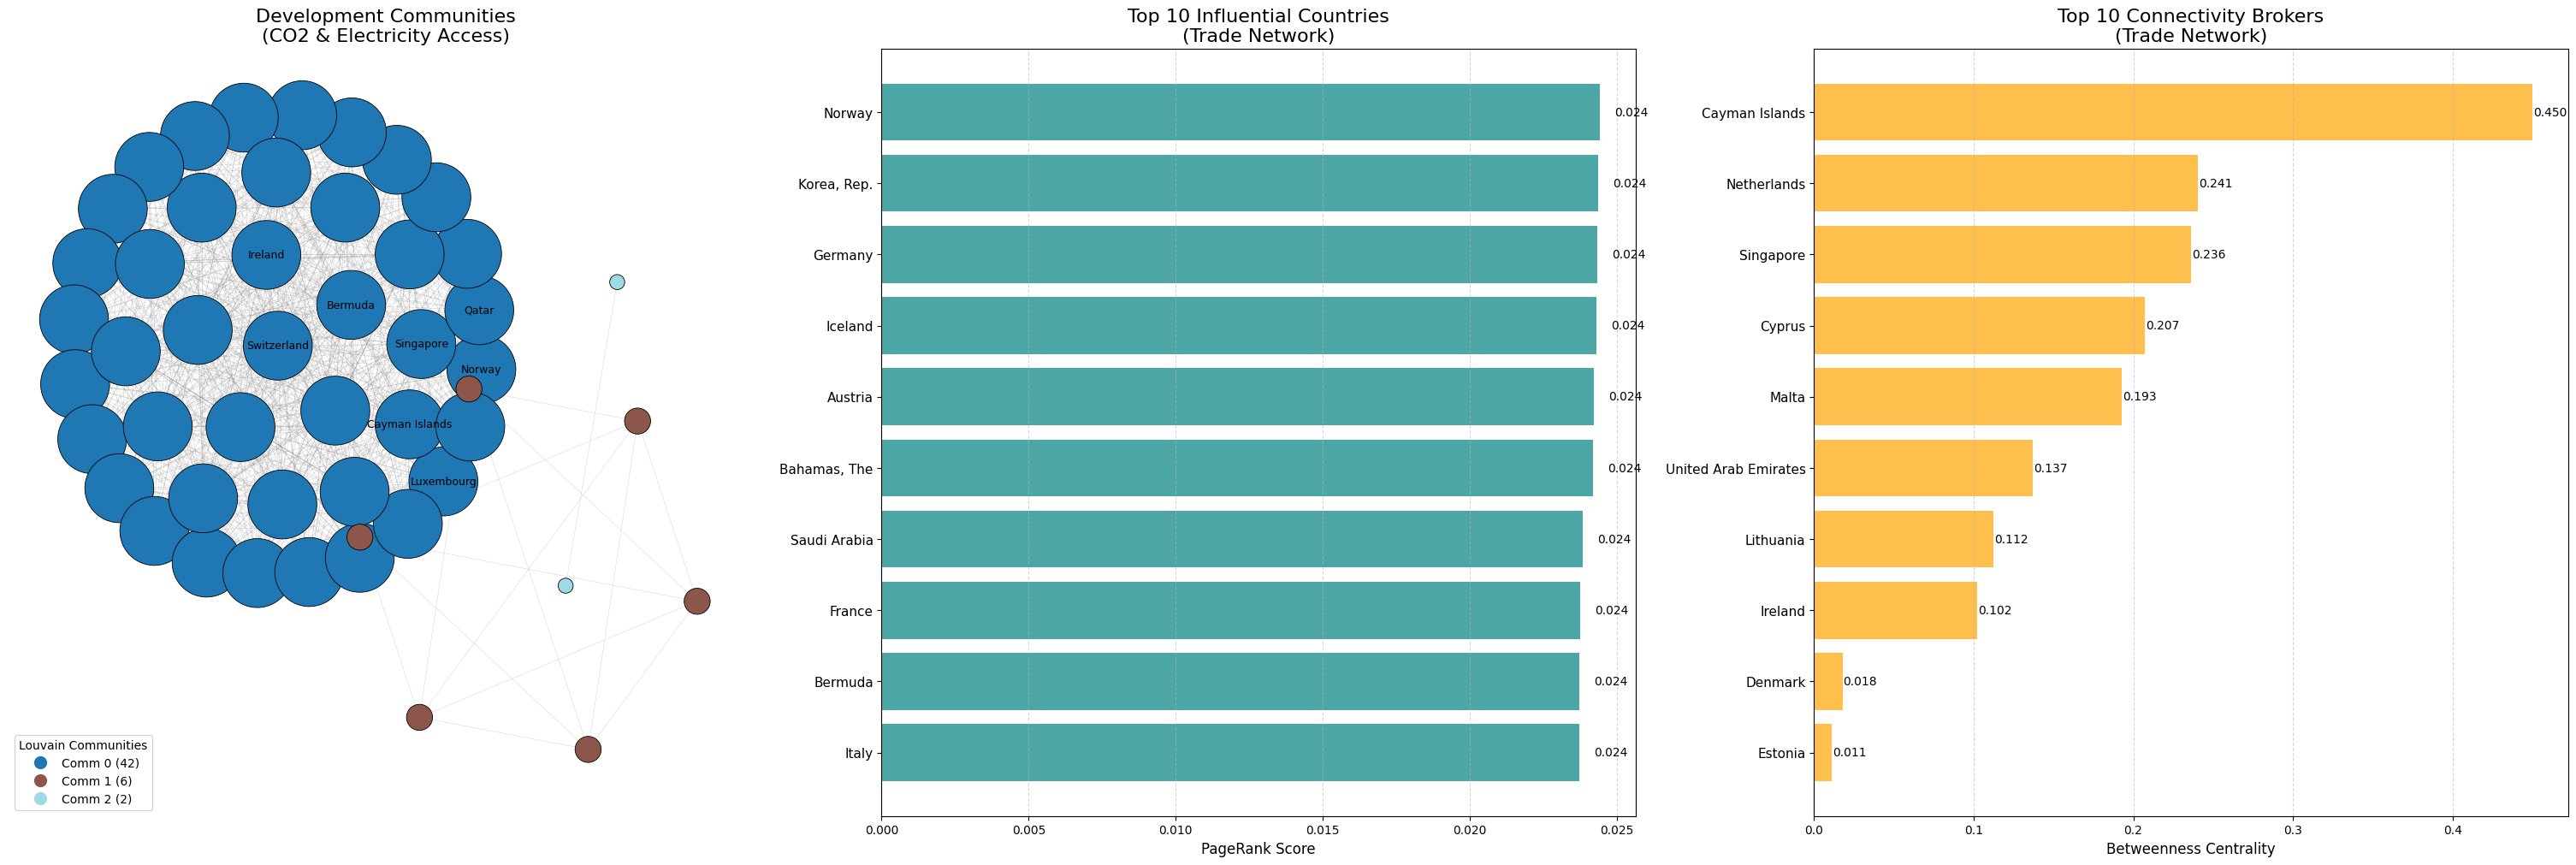

In [15]:

# 1. Prune zero-weight edges from the similarity graph
MIN_W = 0.05
G_sim = nx.Graph()
for n, d in G_similarity.nodes(data=True):
    G_sim.add_node(n, **d)
for u, v, d in G_similarity.edges(data=True):
    w = d.get("weight", 0)
    if w > MIN_W:
        G_sim.add_edge(u, v, weight=w)

# 2. Community detection on pruned similarity graph
if louvain_installed:
    partition = community_louvain.best_partition(G_sim, weight="weight")
    comm_counts = Counter(partition.values())
    comm_ids = sorted(comm_counts)
    palette = plt.cm.tab20(np.linspace(0,1,len(comm_ids)))
    comm_color = {c: palette[i] for i,c in enumerate(comm_ids)}
    node_colors  = [comm_color[partition[n]] for n in G_sim.nodes()]
    node_sizes   = [comm_counts[partition[n]] * 80 for n in G_sim.nodes()]

# 3. Prepare layout once
pos = nx.kamada_kawai_layout(G_sim)

# 4. Build figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(30, 10), constrained_layout=True)

# ——— (A) Communities plot ———
ax = axes[0]
# edges
nx.draw_networkx_edges(
    G_sim, pos, ax=ax,
    alpha=0.4,
    edge_color="gray",
    width=[d["weight"]*0.3 for _,_,d in G_sim.edges(data=True)]
)
# nodes
nx.draw_networkx_nodes(
    G_sim, pos, ax=ax,
    node_color=node_colors,
    node_size=node_sizes,
    edgecolors="black",
    linewidths=0.6
)
# label top 8 by community size
top8 = sorted(G_sim.nodes(),
              key=lambda n: comm_counts[partition[n]],
              reverse=True)[:8]
nx.draw_networkx_labels(G_sim, pos,
                        {n:n for n in top8},
                        font_size=9, ax=ax)
ax.set_title("Development Communities\n(CO2 & Electricity Access)", fontsize=16)
ax.axis("off")
# legend
legend_handles = [
    plt.Line2D([0],[0], marker='o', color='w',
               label=f"Comm {c} ({comm_counts[c]})",
               markerfacecolor=comm_color[c], markersize=12)
    for c in comm_ids
]
ax.legend(handles=legend_handles,
          title="Louvain Communities",
          frameon=True, fontsize=10, loc="lower left")

# ——— (B) PageRank bar chart ———
ax = axes[1]
pr_top = sorted(pr_trade.items(), key=lambda kv: kv[1], reverse=True)[:10]
countries, scores = zip(*pr_top)
y = np.arange(len(countries))

ax.barh(y, scores, color="teal", alpha=0.7)
ax.set_yticks(y); ax.set_yticklabels(countries, fontsize=11)
ax.invert_yaxis()
ax.set_xlabel("PageRank Score", fontsize=12)
ax.set_title("Top 10 Influential Countries\n(Trade Network)", fontsize=16)
ax.grid(axis="x", linestyle="--", alpha=0.5)
for i,v in enumerate(scores):
    ax.text(v + 0.0005, i, f"{v:.3f}", va='center', fontsize=10)

# ——— (C) Betweenness bar chart ———
ax = axes[2]
bc_top = sorted(bc_trade.items(), key=lambda kv: kv[1], reverse=True)[:10]
countries, scores = zip(*bc_top)
y = np.arange(len(countries))

ax.barh(y, scores, color="orange", alpha=0.7)
ax.set_yticks(y); ax.set_yticklabels(countries, fontsize=11)
ax.invert_yaxis()
ax.set_xlabel("Betweenness Centrality", fontsize=12)
ax.set_title("Top 10 Connectivity Brokers\n(Trade Network)", fontsize=16)
ax.grid(axis="x", linestyle="--", alpha=0.5)
for i,v in enumerate(scores):
    ax.text(v + 0.0005, i, f"{v:.3f}", va='center', fontsize=10)

plt.show()



#### Explanation of the Visualization and Analysis

1. **Development Communities (CO2 & Electricity Access)**:
    - The left plot shows communities detected using the Louvain algorithm on the similarity network.
    - Nodes represent countries, and edges indicate similarity in CO2 emissions and electricity access.
    - Communities are color-coded, with larger nodes representing more central countries in their respective communities.

2. **Top 10 Influential Countries (Trade Network)**:
    - The middle bar chart ranks countries by their PageRank scores in the trade network.
    - Higher scores indicate greater influence in global trade, with Norway leading the list.

3. **Top 10 Connectivity Brokers (Trade Network)**:
    - The right bar chart ranks countries by betweenness centrality in the trade network.
    - Countries like the Cayman Islands and Netherlands act as key brokers, connecting otherwise isolated regions.

These insights highlight the role of trade influence and connectivity in global development and the importance of addressing disparities in environmental and infrastructure metrics.



---

### Visualizing the Undirected Networks
We visualize both networks to highlight their structure and the impact of zero-weight edges.

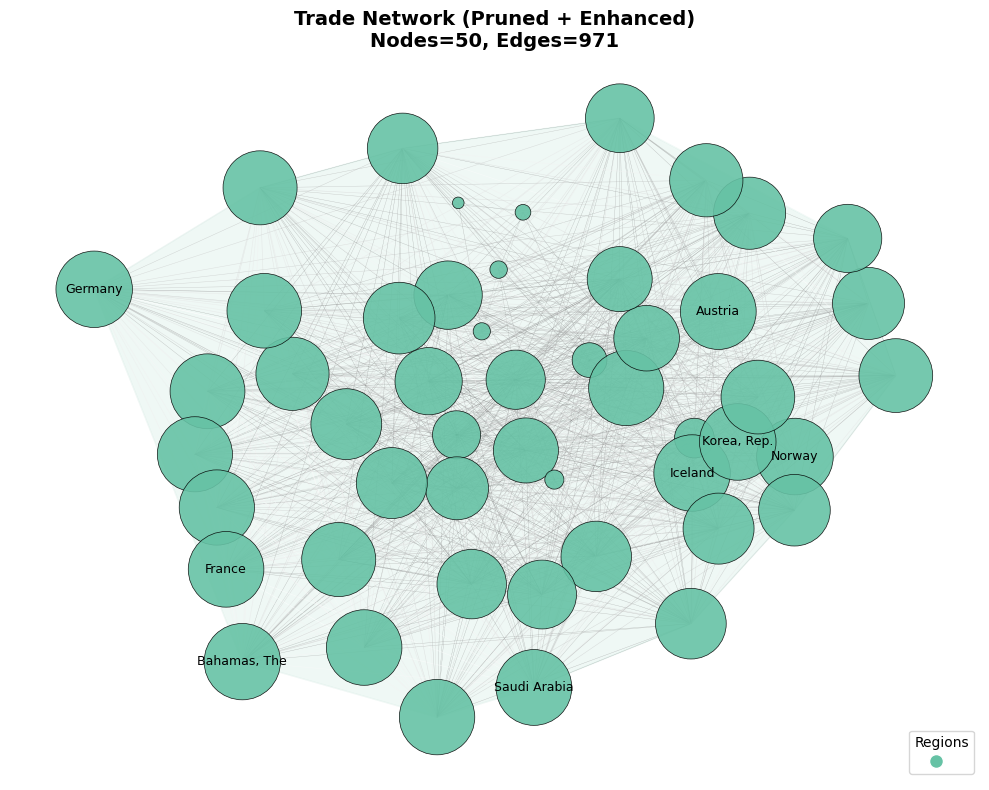

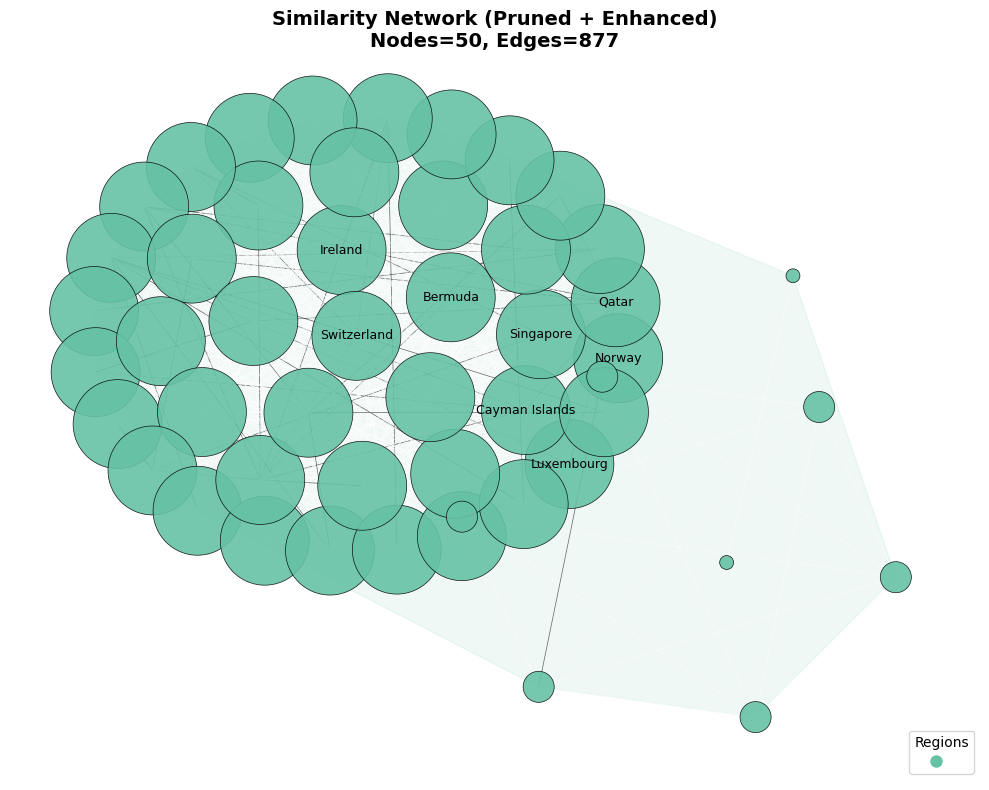

In [16]:

def plot_network(G, title, min_weight=0.05, top_k_labels=8):
    # 1. Build a simple undirected subgraph pruning zero-weight edges
    H = nx.Graph()
    for n, d in G.nodes(data=True):
        H.add_node(n, **d)
    for u, v, d in G.edges(data=True):
        w = d.get("weight", 0.0)
        if w > min_weight:
            H.add_edge(u, v, weight=w)
    
    # 2. Region coloring
    regions = nx.get_node_attributes(H, "region")
    unique_regions = sorted(set(regions.values()))
    palette = plt.cm.Set2(np.linspace(0, 1, len(unique_regions)))
    region_color = dict(zip(unique_regions, palette))
    node_colors = [region_color[regions[n]] for n in H.nodes()]
    
    # 3. Node sizes by weighted degree
    deg = dict(H.degree(weight="weight"))
    node_sizes = [deg[n] * 100 for n in H.nodes()]
    
    # 4. Edge widths by weight
    edge_widths = [d["weight"] * 0.5 for _, _, d in H.edges(data=True)]
    
    # 5. Layout
    pos = nx.kamada_kawai_layout(H)
    
    # 6. Plot
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # 6a. Convex hulls for each region
    for region, color in region_color.items():
        pts = np.array([pos[n] for n in H if regions[n] == region])
        if len(pts) >= 3:
            hull = ConvexHull(pts)
            poly = pts[hull.vertices]
            ax.fill(poly[:, 0], poly[:, 1], color=color, alpha=0.1, zorder=0)
    
    # 6b. Draw edges
    nx.draw_networkx_edges(
        H, pos, ax=ax,
        edge_color=edge_widths,
        edge_cmap=plt.cm.Greys_r,
        width=edge_widths,
        alpha=0.6,
    )
    
    # 6c. Draw nodes
    nx.draw_networkx_nodes(
        H, pos, ax=ax,
        node_size=node_sizes,
        node_color=node_colors,
        edgecolors="black",
        linewidths=0.5,
        alpha=0.9,
    )
    
    # 6d. Label top-k hubs only
    top_nodes = sorted(H.nodes(), key=lambda n: deg[n], reverse=True)[:top_k_labels]
    labels = {n: n for n in top_nodes}
    nx.draw_networkx_labels(H, pos, labels, font_size=9, ax=ax)
    
    # 7. Title and stats
    ax.set_title(f"{title}\nNodes={H.number_of_nodes()}, Edges={H.number_of_edges()}",
                 fontsize=14, fontweight="bold")
    ax.axis("off")
    
    # 8. Legend (regions)
    legend_elems = [
        Line2D([0], [0], marker="o", color="w", label=region,
               markerfacecolor=region_color[region], markersize=10)
        for region in unique_regions
    ]
    ax.legend(handles=legend_elems, title="Regions",
              loc="lower right", frameon=True, fontsize=9)
    
    plt.tight_layout()
    plt.show()

# Finally, call for both graphs:
plot_network(G_trade,      "Trade Network (Pruned + Enhanced)")
plot_network(G_similarity, "Similarity Network (Pruned + Enhanced)")


### Graph 1

The graph represents a **Trade Network** with 50 nodes (countries) and 971 edges (trade relationships). Each node represents a country, and the size of the node reflects its centrality or importance in the network. Edges between nodes are weighted, indicating the strength of trade relationships based on exports and FDI outflows.

Key features:
- **Clusters**: Countries are grouped into clusters based on trade similarity, detected using the Louvain algorithm.
- **Node Size**: Larger nodes indicate higher centrality, such as PageRank or Betweenness Centrality.
- **Edge Weight**: Thicker edges represent stronger trade relationships.
- **Color Coding**: Nodes are color-coded by their region or community.

This visualization highlights influential countries and trade hubs, as well as the structure of global trade relationships.


### Graph 2

The graph visualizes a **Similarity Network** with 50 nodes (countries) and 877 edges (relationships). Each node represents a country, and edges indicate similarity in CO2 emissions and electricity access. 

Key features:
- **Clusters**: Countries are grouped into communities using the Louvain algorithm, highlighting shared development characteristics.
- **Node Size**: Larger nodes represent countries with higher centrality or influence within their community.
- **Edge Weight**: Thicker edges indicate stronger similarity between countries.
- **Color Coding**: Nodes are color-coded by their community, emphasizing regional or developmental clusters.

This visualization helps identify patterns of similarity and gaps in global development metrics.
```